In [22]:
import json
import os
from flask import Flask, render_template, request
from flask_cors import CORS
from helpers.MySQLDatabaseHandler import MySQLDatabaseHandler
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
with open("dataset/cmu.json", "r") as file:
    book_data = json.load(file)
    book_df = pd.DataFrame(book_data)
    book_df = book_df.drop_duplicates(subset="book_title", ignore_index=True)

with open("dataset/netflix.json", "r") as file:
    show_data = json.load(file)
    show_df = pd.DataFrame(show_data)
    show_df = show_df.drop_duplicates(subset="title", ignore_index=True)


In [24]:
def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm="l2"):
    vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        stop_words=stop_words,
        norm=norm,
    )
    return vectorizer


def title_idx_maker(db, ind):
    title_to_idx = {}
    idx_to_title = {}

    for index, row in enumerate(db):
        title_to_idx[row[ind].lower()] = index
        idx_to_title[index] = row[ind]
    return title_to_idx, idx_to_title


book_title_to_idx, book_idx_to_title = title_idx_maker(book_data, "book_title")
netflix_title_to_idx, netflix_idx_to_title = title_idx_maker(show_data, "title")

n_feats = 10000
doc_by_vocab = np.empty([len(book_data), n_feats])
tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform(
    [row["plot_summary"] for index, row in enumerate(book_data)]
).toarray()
index_to_vocab = {i: v for i, v in enumerate(tfidf_vec.get_feature_names_out())}

query_by_vocab = np.empty([len(show_data), n_feats])

query_by_vocab = tfidf_vec.transform(
    [row["description"] for index, row in enumerate(show_data)]
).toarray()

SVD time!!
---
Approach 1: 
1. Fit SVD on book dataset
2. Transform both movie and book datasets


In [25]:
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=42)

In [26]:
trained_svd = svd.fit(doc_by_vocab)

In [27]:
svd_books = trained_svd.transform(doc_by_vocab)
svd_netflix = trained_svd.transform(query_by_vocab)

In [28]:
zero_to_1_scaler = MinMaxScaler().fit(svd_books)

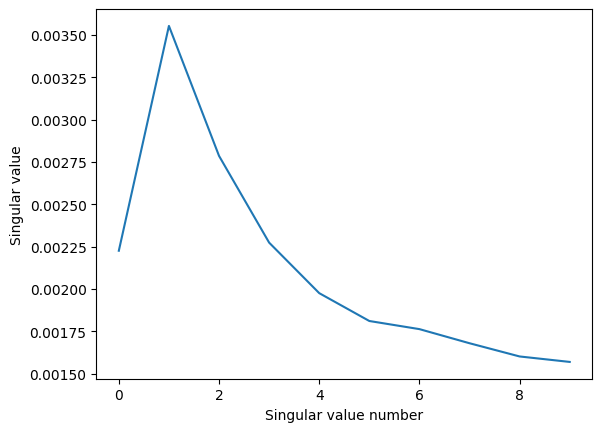

In [29]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(trained_svd.explained_variance_ratio_)
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()


In [30]:
#This is how you access compressed words trained_svd.components_[:,4000].shape
reshaped_words = trained_svd.components_.T

In [31]:
from sklearn.preprocessing import normalize
compressed_terms = normalize(reshaped_words)

In [32]:
normalized_book_mat = zero_to_1_scaler.transform(svd_books)

In [33]:
# cosine similarity
word_to_index = tfidf_vec.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [34]:
word = 'dog'
print("Using SVD:")
for w, sim in closest_words(word, compressed_terms):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()

Using SVD:
peach, 0.962
scares, 0.953
ma, 0.949
woods, 0.940
toy, 0.937
cat, 0.931
camping, 0.929
graveyard, 0.922
bites, 0.919
jonathan, 0.916



In [35]:
import scipy
import plotly.express as px
def get_sim_book(netflix_titles,book_mat):
    #if input is empty, replace input with a string
    if not netflix_titles:
        netflix_titles = [""]
    lower_titles=[a.lower() for a in netflix_titles]
    netflix_vectors=[]
    for lower_title in lower_titles:
        if lower_title in netflix_title_to_idx:
            netflix_idx = netflix_title_to_idx[lower_title]
            netflix_vec = svd_netflix[netflix_idx]
            netflix_vectors.append(netflix_vec)
      # TODO Fix this nonsense
        else:
            #return book_mat
            tf_idf_query= scipy.sparse.csr_matrix.toarray(tfidf_vec.transform([lower_title]))
            query_vec = trained_svd.transform(tf_idf_query).reshape(10,)
            print(f"{query_vec.shape=}")
            netflix_vectors.append(query_vec)
    avg_vector = np.mean(netflix_vectors, axis=0).reshape(1, -1)
    similarities = cosine_similarity(avg_vector, book_mat)
    return similarities


def book_sims_to_recs(book_sims, book_idx_to_title, book_mat):
    if np.array_equal(book_sims, book_mat):
        return [("This title is not in our database.", None)]
    else:
        #sim_pairs = [(book_idx_to_title[i], sim) for i, sim in enumerate(book_sims[0])]
        title_sim_vec = [(book_idx_to_title[i], sim, normalized_book_mat[i].tolist()) for i, sim in enumerate(book_sims[0])]
        #top_5_vecs = [zero_to_1_scaler.transform(book_mat[i].reshape(1, -1))[0] for i, _ in enumerate(book_sims[0])]
        #print(top_5_vecs)
        top_5 = sorted(title_sim_vec, key=lambda x: x[1], reverse=True)[:5]
        return top_5


def rec_books(netflix_title, book_mat, book_idx_to_title):
    assert book_mat is not None and book_idx_to_title is not None
    similarities = get_sim_book(netflix_title, book_mat)

    top_5 = book_sims_to_recs(similarities, book_idx_to_title, book_mat)
    # top_5_list = [tup[0] for tup in top_5]
    top_5_list = [tup for tup in top_5]
    print(f"{top_5_list=}")
    # matches = (book_data[top_5]).to_json(orient="records")
    # print(top_5)

    matches = json.dumps(top_5_list)

    dimension_titles = ["Epic", "Violent", "Historical", "Regal", "Sneaky", "Dramatic", "Miserable", "Hopeful", "Contemplative", "Mysterious"]

    print(f"The 5 most similar books to {netflix_title} are:")
    for index, (book_title, sim_score, vec) in enumerate(top_5):
        print(f"\n{index+1}. {book_title}")
        df = pd.DataFrame(dict(
        r=vec,
        theta=dimension_titles))
        fig = px.line_polar(df, r='r', theta='theta', line_close=True)
        fig.show()
    return matches

In [41]:
rec_books(["Sherlock Holmes"], svd_books, book_idx_to_title)

top_5_list=[('Amorality Tale', 0.9209701593693987, [0.1832866293559003, 0.4714780632870916, 0.42392394033295844, 0.3257359981550126, 0.4608763885467847, 0.49900045434967744, 0.31269209587793634, 0.6742641789855115, 0.4788165732285615, 0.18202142187881049]), ('All-Consuming Fire', 0.9116572977911581, [0.15425925450546238, 0.48813705883440145, 0.39826172781807156, 0.2414398438163549, 0.5465710077605197, 0.5205901852370575, 0.14329778767475, 0.8336336896792732, 0.5876570123961125, 0.08639914999725318]), ('The Deviant Strain', 0.9076694319575561, [0.19328528321400626, 0.5578084624716144, 0.3696808709067494, 0.21866062799599473, 0.5437259805990606, 0.5455382818053676, 0.1943448398548388, 0.6251571820733267, 0.460833387791146, 0.0682754931327417]), ('The Empire of Glass', 0.9055830826264617, [0.174102446352529, 0.5379514152164261, 0.4176582793708844, 0.3001628091032976, 0.39482171337419947, 0.5218957793258787, 0.25040478453100135, 0.667904206727613, 0.5077037108418826, 0.15934658862184942]),


2. All-Consuming Fire



3. The Deviant Strain



4. The Empire of Glass



5. Verdigris


'[["Amorality Tale", 0.9209701593693987, [0.1832866293559003, 0.4714780632870916, 0.42392394033295844, 0.3257359981550126, 0.4608763885467847, 0.49900045434967744, 0.31269209587793634, 0.6742641789855115, 0.4788165732285615, 0.18202142187881049]], ["All-Consuming Fire", 0.9116572977911581, [0.15425925450546238, 0.48813705883440145, 0.39826172781807156, 0.2414398438163549, 0.5465710077605197, 0.5205901852370575, 0.14329778767475, 0.8336336896792732, 0.5876570123961125, 0.08639914999725318]], ["The Deviant Strain", 0.9076694319575561, [0.19328528321400626, 0.5578084624716144, 0.3696808709067494, 0.21866062799599473, 0.5437259805990606, 0.5455382818053676, 0.1943448398548388, 0.6251571820733267, 0.460833387791146, 0.0682754931327417]], ["The Empire of Glass", 0.9055830826264617, [0.174102446352529, 0.5379514152164261, 0.4176582793708844, 0.3001628091032976, 0.39482171337419947, 0.5218957793258787, 0.25040478453100135, 0.667904206727613, 0.5077037108418826, 0.15934658862184942]], ["Verdigr

In [37]:
for i in range(10):
    print("Top words in dimension", i)
    dimension_col = compressed_terms[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:20]])
    print()

Top words in dimension 0
['long', 'moments', 'ends', 'secrecy', 'begins', 'end', 'surprisingly', 'close', 'passing', 'ironically', 'takes', 'initially', 'turned', 'halfway', 'taking', 'standing', 'abruptly', 'stand', 'hopes', 'makes']

Top words in dimension 1
['apollo', 'destruction', 'commonwealth', 'thor', 'envoy', 'terminus', 'weaponry', 'polar', 'factions', 'designed', 'brazil', 'destroyed', 'mutated', 'destroy', 'massive', 'cataclysm', 'zone', 'monopoly', 'activated', 'orbital']

Top words in dimension 2
['1960s', '1940s', '1920s', '1970s', 'interactions', '1973', 'narratives', 'focuses', 'explores', 'gradual', 'portrays', 'chronological', 'contemporary', '1960', 'parallels', 'narrates', 'experiences', 'central', '1996', '1980s']

Top words in dimension 3
['egypt', 'reign', 'kings', 'princes', 'kingdom', 'kingdoms', 'marches', 'holy', 'throne', 'famed', 'monarch', 'thebes', 'judah', 'proclaimed', 'norse', 'pagan', 'rupert', 'crown', 'roman', 'nobility']

Top words in dimension 4
